# Test our method on the NLTT proper motion catalog

In [158]:
import os
import sys
sys.path.append('../src')
import P_binary
import P_random
import const as c
import time
import glob
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import uniform, normal
from scipy.optimize import newton
from scipy import stats
from astropy.table import Table
from astropy import units as u
from astropy.coordinates import SkyCoord
import corner
from scipy.interpolate import interp1d, interp2d
from scipy.stats import gaussian_kde
import pickle


%matplotlib inline

In [159]:
# Read in sample from Tycho-2 table
filename = ('../data/rNLTT/catalog_tabs.dat')
t = Table.read(filename, format='ascii', guess=True)

# Change proper motion units from asec/yr to mas/yr
t['mu_ra'] = 1.0e3*t['mu_ra']
t['mu_dec'] = 1.0e3*t['mu_dec']
t['mu_ra_err'] = 1.0e3*t['mu_ra_err']
t['mu_dec_err'] = 1.0e3*t['mu_dec_err']

# Set minimum proper motion uncertainties to 1 mas/yr
min_t = np.ones(len(t))
t['mu_ra_err'] = np.max((min_t, t['mu_ra_err']), axis=0)
t['mu_dec_err'] = np.max((min_t, t['mu_dec_err']), axis=0)

In [160]:
print t.colnames
print len(t['ra'])

['NLTT', 'ra', 'dec', 'mu_ra', 'mu_dec', 'mu_ra_err', 'mu_dec_err', 'V', 'B', 'R', 'J', 'H', 'K']
36085


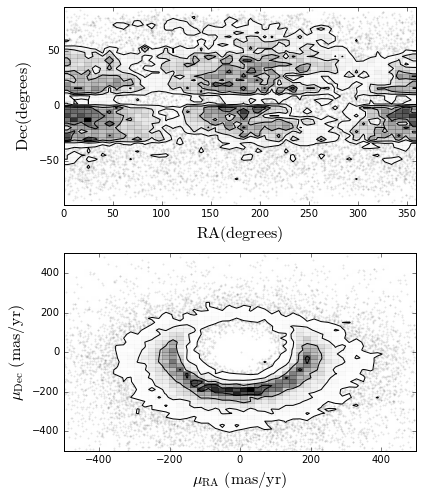

In [161]:
fig, ax = plt.subplots(2,1, figsize=(6,7))

contourf_kwargs = {'bins':50}
corner.hist2d(t['ra'], t['dec'], range=[(0,360),(-90,90)], ax=ax[0], **contourf_kwargs)
#plt.scatter(t['ra'], t['dec'], marker='.', alpha=0.1)
ax[0].set_xlim(0,360)
ax[0].set_ylim(-90,90)
ax[0].set_xlabel(r'${\rm RA (degrees)}$', size=16)
ax[0].set_ylabel(r'${\rm Dec (degrees)}$', size=16)

contourf_kwargs = {'bins':50}
corner.hist2d(t['mu_ra'], t['mu_dec'], range=[(-500,500),(-500,500)], ax=ax[1], **contourf_kwargs)
#corner.hist2d(t['mu_ra']*1.0e3*np.cos(t['dec']*np.pi/180.0), t['mu_dec']*1.0e3, range=[(-500,500),(-500,500)], ax=ax[1], **contourf_kwargs)
#plt.scatter(t['mu_ra'], t['mu_dec'], marker='.', alpha=0.1)
ax[1].set_xlabel(r'$\mu_{\rm RA}\ {\rm (mas/yr)}$', size=16)
ax[1].set_ylabel(r'$\mu_{\rm Dec}\ {\rm (mas/yr)}$', size=16)
ax[1].set_xlim(-500,500)
ax[1].set_ylim(-500,500)

#plt.axes().set_aspect('equal')
plt.tight_layout()
#plt.savefig('../figures/rNLTT_pos_mu.pdf')
plt.show()

### Generate set of binaries

In [162]:
P_binary.generate_binary_set(num_sys=1000000)

### Find probabilities for rNLTT catalog

In [417]:
length = len(t)
#length = 40
print "We are testing", length, "stars..."

dtype = [('i_1','i4'),('i_2','i4'),('NLTT_1','i4'),('NLTT_2','i4'),('P_random','f8'),('P_binary','f8'),('P_posterior','f8')]
prob_out = np.zeros(length, dtype=dtype)

for i in np.arange(length-1):
    
    if i%1000 == 0: print i
    
    star1 = t['ra'][i], t['dec'][i], t['mu_ra'][i], t['mu_dec'][i], t['mu_ra_err'][i], t['mu_dec_err'][i]

    
    # Random Alignment densities
    pos_density = P_random.get_sigma_pos(star1[0], star1[1], catalog=t, method='kde')
    pm_density = P_random.get_sigma_mu(star1[2], star1[3], catalog=t, method='kde')

    
    prob = np.zeros(len(t)-i-1)
    for j in np.arange(len(t)-i-1)+i+1:

        if t['NLTT'][i] == t['NLTT'][j]:
            prob[j-i-1] = 1000.0
            continue
            
        star2 = t['ra'][j], t['dec'][j], t['mu_ra'][j], t['mu_dec'][j], t['mu_ra_err'][j], t['mu_dec_err'][j]
        
        delta_pm_ra_err = np.sqrt(star1[4]**2 + star2[4]**2)
        delta_pm_dec_err = np.sqrt(star1[5]**2 + star2[5]**2)
                
        
        prob[j-i-1], P_pos, P_mu = P_random.get_P_random_alignment(star1[0], star1[1], star2[0], star2[1],
                                          star1[2], star1[3], star2[2], star2[3], 
                                          delta_mu_ra_err=delta_pm_ra_err, delta_mu_dec_err=delta_pm_dec_err,
                                          pos_density=pos_density, pm_density=pm_density,
                                          catalog=t)
        
    # Get best matching pair
    j = np.argmin(prob)+i+1
    star2 = t['ra'][j], t['dec'][j], t['mu_ra'][j], t['mu_dec'][j], t['mu_ra_err'][j], t['mu_dec_err'][j]    
    theta = P_random.get_theta_proj_degree(star1[0], star1[1], star2[0], star2[1]) * 3600.0
    delta_mu = np.sqrt((star1[2]-star2[2])**2 + (star1[3]-star2[3])**2)
    delta_mu_ra_err = np.sqrt(star1[4]**2 + star2[4]**2)
    delta_mu_dec_err = np.sqrt(star1[5]**2 + star2[5]**2)

    # Only include binary probability if star is within 1 degree
    if theta > 3600.0:
        prob_binary = 0.0
    else:
        delta_mu_ra_sample = normal(loc=(star1[2]-star2[2]), scale=delta_mu_ra_err, size=100)
        delta_mu_dec_sample = normal(loc=(star1[3]-star2[3]), scale=delta_mu_dec_err, size=100)
        delta_mu_sample = np.sqrt(delta_mu_ra_sample**2 + delta_mu_dec_sample**2)
        prob_binary = 1.0/100 * np.sum(P_binary.get_P_binary(theta, delta_mu_sample))

    prob_out['i_1'][i] = i
    prob_out['i_2'][i] = j
    prob_out['NLTT_1'][i] = t['NLTT'][i]
    prob_out['NLTT_2'][i] = t['NLTT'][j]
    prob_out['P_random'][i] = prob[j-i-1]
    prob_out['P_binary'][i] = prob_binary
    prob_out['P_posterior'][i] = prob_binary / (prob[j-i-1] + prob_binary + 1.0e-99)
    
print "... finished"

We are testing 36085 stars...
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
... finished


In [418]:
pickle.dump(prob_out, open("../data/rNLTT/prob_out.data", "wb"))

In [163]:
# Read in pairs identified by Chaname & Gould

filename_CG = ('../data/rNLTT/Chaname_Gould_pairs.dat')
CG_pairs = Table.read(filename_CG, format='cds')
print CG_pairs.colnames

['NLTT-A', 'NLTT-B', 'RAdegA', 'DEdegA', 'RAdegB', 'DEdegB', 'pmRA-A', 'pmDE-A', 'pmRA-B', 'pmDE-B', 'VmagA', '(V-J)A', 'VmagB', '(V-J)B', 'SC-A', 'SC-B', 'CCode', 'Delpm', 'DelSep', 'PosAng', 'Bin', 'Allen']


In [165]:

dtype = [('NLTT_1','i4'),('NLTT_2','i4'),('P_random','f8'),('P_binary','f8'),\
         ('P_theta','f8'),('P_mu','f8'),('P_posterior','f8'),('CCode','i4')]
prob_out_CG = np.array([], dtype=dtype)

for pair in CG_pairs:
    
    if len(prob_out_CG)%100 == 0: print len(prob_out_CG)
    
#    print pair['NLTT-A'], pair['NLTT-B'], pair['CCode']

    # Check if there is a match for star 1
    if len(np.where(pair['NLTT-A'] == t['NLTT'])[0]) == 0:
        continue

    # Check if there is a match for star 2
    if len(np.where(pair['NLTT-B'] == t['NLTT'])[0]) == 0:
        continue

    # Star 1
    star1 = t['ra'][np.where(pair['NLTT-A'] == t['NLTT'])][0], \
        t['dec'][np.where(pair['NLTT-A'] == t['NLTT'])][0], \
        t['mu_ra'][np.where(pair['NLTT-A'] == t['NLTT'])][0], \
        t['mu_dec'][np.where(pair['NLTT-A'] == t['NLTT'])][0], \
        t['mu_ra_err'][np.where(pair['NLTT-A'] == t['NLTT'])][0], \
        t['mu_dec_err'][np.where(pair['NLTT-A'] == t['NLTT'])][0]

    # Star 2
    star2 = t['ra'][np.where(pair['NLTT-B'] == t['NLTT'])][0], \
        t['dec'][np.where(pair['NLTT-B'] == t['NLTT'])][0], \
        t['mu_ra'][np.where(pair['NLTT-B'] == t['NLTT'])][0], \
        t['mu_dec'][np.where(pair['NLTT-B'] == t['NLTT'])][0], \
        t['mu_ra_err'][np.where(pair['NLTT-B'] == t['NLTT'])][0], \
        t['mu_dec_err'][np.where(pair['NLTT-B'] == t['NLTT'])][0]

        
    delta_pm_ra_err = np.sqrt(star1[4]**2 + star2[4]**2)
    delta_pm_dec_err = np.sqrt(star1[5]**2 + star2[5]**2)
                
        
    # Get probability of random alignment
    prob_random, P_pos, P_mu = P_random.get_P_random_alignment(star1[0], star1[1], star2[0], star2[1],
                                          star1[2], star1[3], star2[2], star2[3], 
                                          delta_mu_ra_err=delta_pm_ra_err, delta_mu_dec_err=delta_pm_dec_err,
                                          catalog=t)

    # Get probability due to true binary
    theta = P_random.get_theta_proj_degree(star1[0], star1[1], star2[0], star2[1]) * 3600.0
    delta_mu = np.sqrt((star1[2]-star2[2])**2 + (star1[3]-star2[3])**2)
    delta_mu_ra_err = np.sqrt(star1[4]**2 + star2[4]**2)
    delta_mu_dec_err = np.sqrt(star1[5]**2 + star2[5]**2)
    if theta > 3600.0:
        prob_binary = 0.0
    else:
        delta_mu_ra_sample = normal(loc=(star1[2]-star2[2]), scale=delta_mu_ra_err, size=100)
        delta_mu_dec_sample = normal(loc=(star1[3]-star2[3]), scale=delta_mu_dec_err, size=100)
        delta_mu_sample = np.sqrt(delta_mu_ra_sample**2 + delta_mu_dec_sample**2)
        prob_binary = 1.0/100 * np.sum(P_binary.get_P_binary(theta, delta_mu_sample))

    prob_temp = np.zeros(1, dtype=dtype)
    prob_temp['NLTT_1'][0] = pair['NLTT-A']
    prob_temp['NLTT_2'][0] = pair['NLTT-B']
    prob_temp['P_random'][0] = prob_random
    prob_temp['P_binary'][0] = prob_binary
    prob_temp['P_theta'][0] = P_pos
    prob_temp['P_mu'][0] = P_mu
    prob_temp['P_posterior'][0] = prob_binary / (prob_random + prob_binary)
    prob_temp['CCode'][0] = pair['CCode']
        
    prob_out_CG = np.append(prob_out_CG, prob_temp[0])

0
100
200
300
400
500
600
700
800
900
1000


In [166]:
pickle.dump(prob_out_CG, open("../data/rNLTT/prob_out_CG.data", "wb"))

In [167]:
print len(prob_out_CG)
print prob_out_CG.dtype

1067
[('NLTT_1', '<i4'), ('NLTT_2', '<i4'), ('P_random', '<f8'), ('P_binary', '<f8'), ('P_theta', '<f8'), ('P_mu', '<f8'), ('P_posterior', '<f8'), ('CCode', '<i4')]


In [229]:
pair_CG_accept = prob_out_CG[np.where(prob_out_CG['CCode'] < 4)]
pair_CG_reject = prob_out_CG[np.where(prob_out_CG['CCode'] > 3)]

print "There are", len(pair_GC_accept), "accepted binaries"
print "...and", len(pair_GC_reject), "rejected binaries."

There are 934 accepted binaries
...and 133 rejected binaries.


In [232]:
# Set zero probabilities to some arbitrarily small number
pair_CG_accept['P_random'][np.where(pair_CG_accept['P_random'] == 0.0)] = 1.0e-50
pair_CG_reject['P_random'][np.where(pair_CG_reject['P_random'] == 0.0)] = 1.0e-50
pair_CG_accept['P_binary'][np.where(pair_CG_accept['P_binary'] == 0.0)] = 1.0e-55
pair_CG_reject['P_binary'][np.where(pair_CG_reject['P_binary'] == 0.0)] = 1.0e-55


P_CG_accept = pair_CG_accept['P_binary'] / (pair_CG_accept['P_random'] + pair_CG_accept['P_binary'])
P_CG_reject = pair_CG_reject['P_binary'] / (pair_CG_reject['P_random'] + pair_CG_reject['P_binary'])
P_full = prob_out['P_binary'] / (prob_out['P_binary'] + prob_out['P_random'] + 1.0e-50)
P_full[np.where(np.isnan(P_full))] = 1.0e-50

In [105]:
prob_out = pickle.load( open("../data/rNLTT/prob_out.data", "rb"))

print len(prob_out)

20


In [260]:
print len(prob_out), len(prob_out[np.where(prob_out["P_posterior"] > 0.0)])

36085 1139


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log10


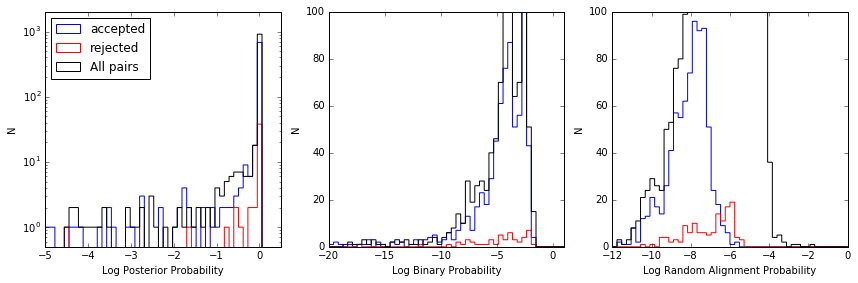

In [419]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

nbins = 50

# Full posterior
xmin, xmax = -5, 0.5
ax[0].hist(np.log10(P_CG_accept), bins=nbins, histtype='step', color='b', range=[xmin, xmax], label='accepted')
ax[0].hist(np.log10(P_CG_reject), bins=nbins, histtype='step', color='r', range=[xmin, xmax], label='rejected')
ax[0].hist(np.log10(P_full), bins=nbins, histtype='step', color='k', range=[xmin, xmax], label='All pairs')

# ax[0].set_xscale('log')
ax[0].set_xlim(xmin, xmax)
ax[0].set_ylim(0.5, 2000.0)
ax[0].set_yscale('log')
ax[0].set_xlabel('Log Posterior Probability')
ax[0].set_ylabel('N')

ax[0].legend(loc=2)



# P_binary
xmin, xmax = -20, 1.0
ax[1].hist(np.log10(pair_CG_accept['P_binary']), bins=nbins, histtype='step', color='b', range=[xmin, xmax])
ax[1].hist(np.log10(pair_CG_reject['P_binary']), bins=nbins, histtype='step', color='r', range=[xmin, xmax])
ax[1].hist(np.log10(prob_out['P_binary'][np.where(prob_out['P_binary'] > 0.0)]), bins=nbins, histtype='step', color='k', range=[xmin, xmax])

ax[1].set_xlim(xmin, xmax)
ax[1].set_ylim(0.0, 100.0)
ax[1].set_xlabel('Log Binary Probability')
ax[1].set_ylabel('N')



# P_random
xmin, xmax = -12,0
ax[2].hist(np.log10(pair_CG_accept['P_random']), bins=nbins, histtype='step', color='b', range=[xmin, xmax])
ax[2].hist(np.log10(pair_CG_reject['P_random']), bins=nbins, histtype='step', color='r', range=[xmin, xmax])
ax[2].hist(np.log10(prob_out['P_random'][np.where(prob_out['P_random'] > 0.0)]), bins=nbins, histtype='step', color='k', range=[xmin, xmax])

ax[2].set_xlim(xmin, xmax)
ax[2].set_ylim(0.0, 100.0)
ax[2].set_xlabel('Log Random Alignment Probability')
ax[2].set_ylabel('N')

plt.tight_layout()
plt.savefig('../figures/Prob_CG05.pdf')
plt.show()

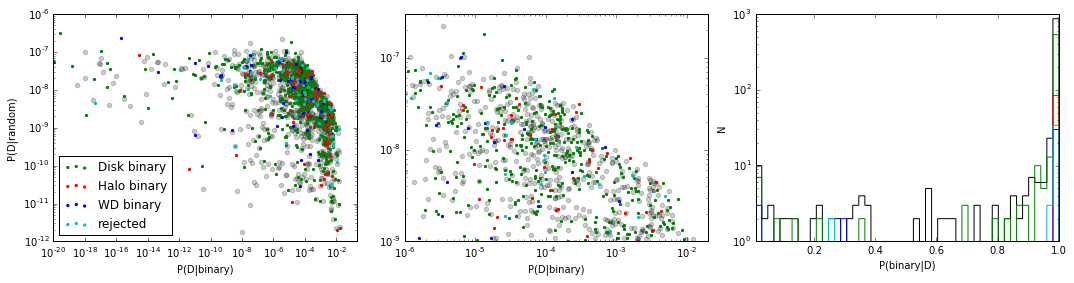

In [420]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))


# Plot entire NLTT catalog
ax[0].scatter(prob_out['P_binary'], prob_out['P_random'], color='k', alpha=0.2)
# Plot Chaname & Gould (2004) pairs
ids = np.where(prob_out_CG['CCode'] == 1)
ax[0].scatter(prob_out_CG['P_binary'][ids], prob_out_CG['P_random'][ids], color='g', label='Disk binary', s=5)
ids = np.where(prob_out_CG['CCode'] == 2)
ax[0].scatter(prob_out_CG['P_binary'][ids], prob_out_CG['P_random'][ids], color='r', label='Halo binary', s=5)
ids = np.where(prob_out_CG['CCode'] == 3)
ax[0].scatter(prob_out_CG['P_binary'][ids], prob_out_CG['P_random'][ids], color='b', label='WD binary', s=5)
ids = np.where(prob_out_CG['CCode'] > 3)
ax[0].scatter(prob_out_CG['P_binary'][ids], prob_out_CG['P_random'][ids], color='c', label='rejected', s=5)

ax[0].set_xlim(1.0e-20, 0.2)
ax[0].set_ylim(1.0e-12, 1.0e-6)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlabel('P(D|binary)')
ax[0].set_ylabel('P(D|random)')
ax[0].legend(loc=3)



# Plot entire NLTT catalog
ax[1].scatter(prob_out['P_binary'], prob_out['P_random'], color='k', alpha=0.2)
# Plot Chaname & Gould (2004) pairs
ids = np.where(prob_out_CG['CCode'] == 1)
ax[1].scatter(prob_out_CG['P_binary'][ids], prob_out_CG['P_random'][ids], color='g', label='Disk binary', s=5)
ids = np.where(prob_out_CG['CCode'] == 2)
ax[1].scatter(prob_out_CG['P_binary'][ids], prob_out_CG['P_random'][ids], color='r', label='Halo binary', s=5)
ids = np.where(prob_out_CG['CCode'] == 3)
ax[1].scatter(prob_out_CG['P_binary'][ids], prob_out_CG['P_random'][ids], color='b', label='WD binary', s=5)
ids = np.where(prob_out_CG['CCode'] > 3)
ax[1].scatter(prob_out_CG['P_binary'][ids], prob_out_CG['P_random'][ids], color='c', label='Rejected', s=5)

ax[1].set_xlim(1.0e-6, 2.0e-2)
ax[1].set_ylim(1.0e-9, 3.0e-7)
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel('P(D|binary)')






xmin, xmax = 0.01, 1.0
bins=40
# Plot entire NLTT catalog
ax[2].hist(prob_out['P_posterior'], histtype='step', color='k', range=[xmin,xmax], bins=nbins)
# Plot Chaname & Gould (2004) pairs
ids = np.intersect1d(np.where(prob_out_CG['CCode'] == 1), np.where(prob_out_CG['P_posterior']>1.0e-10))
ax[2].hist(prob_out_CG['P_posterior'][ids], histtype='step', color='g', range=[xmin, xmax], bins=nbins)
ids = np.intersect1d(np.where(prob_out_CG['CCode'] == 2), np.where(prob_out_CG['P_posterior']>1.0e-10))
ax[2].hist(prob_out_CG['P_posterior'][ids], histtype='step', color='r', range=[xmin, xmax], bins=nbins)
ids = np.intersect1d(np.where(prob_out_CG['CCode'] == 3), np.where(prob_out_CG['P_posterior']>1.0e-10))
ax[2].hist(prob_out_CG['P_posterior'][ids], histtype='step', color='b', range=[xmin, xmax], bins=nbins)
ids = np.intersect1d(np.where(prob_out_CG['CCode'] >3), np.where(prob_out_CG['P_posterior']>1.0e-10))
ax[2].hist(prob_out_CG['P_posterior'][ids], histtype='step', color='c', range=[xmin, xmax], bins=nbins)

ax[2].set_xlim(xmin, xmax)
# ax[1].set_ylim(1.0e-9, 3.0e-7)
#ax[2].set_xscale('log')
ax[2].set_yscale('log')
ax[2].set_xlabel('P(binary|D)')
ax[2].set_ylabel('N')





plt.tight_layout()
#plt.show()

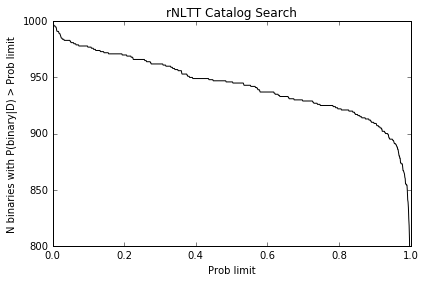

In [421]:
#print len(np.where(prob_out['P_posterior']>0.5)[0])
#print len(np.where(prob_out['P_posterior']>0.2)[0])

x_ran = np.linspace(0.0001, 1.0, 1000)
y = np.zeros(len(x_ran))
for i in np.arange(len(x_ran)):
    
    y[i] = len(np.where(prob_out['P_posterior']>x_ran[i])[0])
    
plt.plot(x_ran, y, color='k')

plt.ylim(800,1000)

plt.title('rNLTT Catalog Search')
plt.xlabel('Prob limit')
plt.ylabel('N binaries with P(binary|D) > Prob limit')

plt.tight_layout()
plt.savefig('../figures/rNLTT_P_posterior.pdf')
#plt.show()

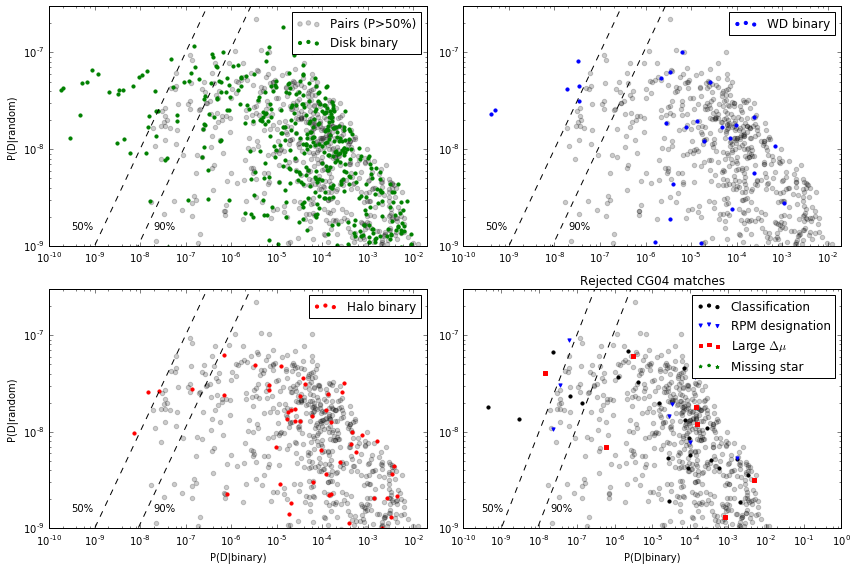

In [422]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8))

id_good = np.where(prob_out['P_posterior']>0.5)


# Plot entire NLTT catalog
p_limit = 0.9
x_tmp = np.linspace(1.0e-10, 2.0e-2, 100)
y_tmp = (1.0/p_limit) * (1.0-p_limit)*x_tmp
ax[0,0].plot(x_tmp, y_tmp, color='k', linestyle='dashed')
ax[0,0].text(2.0e-8, 1.5e-9, '90%')
ax[0,1].plot(x_tmp, y_tmp, color='k', linestyle='dashed')
ax[0,1].text(2.0e-8, 1.5e-9, '90%')
ax[1,0].plot(x_tmp, y_tmp, color='k', linestyle='dashed')
ax[1,0].text(2.0e-8, 1.5e-9, '90%')
ax[1,1].plot(x_tmp, y_tmp, color='k', linestyle='dashed')
ax[1,1].text(2.0e-8, 1.5e-9, '90%')
p_limit = 0.5
x_tmp = np.linspace(1.0e-10, 2.0e-2, 100)
y_tmp = (1.0/p_limit) * (1.0-p_limit)*x_tmp
ax[0,0].plot(x_tmp, y_tmp, color='k', linestyle='dashed')
ax[0,0].text(3.0e-10, 1.5e-9, '50%')
ax[0,1].plot(x_tmp, y_tmp, color='k', linestyle='dashed')
ax[0,1].text(3.0e-10, 1.5e-9, '50%')
ax[1,0].plot(x_tmp, y_tmp, color='k', linestyle='dashed')
ax[1,0].text(3.0e-10, 1.5e-9, '50%')
ax[1,1].plot(x_tmp, y_tmp, color='k', linestyle='dashed')
ax[1,1].text(3.0e-10, 1.5e-9, '50%')


ax[0,0].scatter(prob_out['P_binary'][id_good], prob_out['P_random'][id_good], color='k', alpha=0.2, label='Pairs (P>50%)')
# Plot Chaname & Gould (2004) pairs
ids = np.where(prob_out_CG['CCode'] == 1)
ax[0,0].scatter(prob_out_CG['P_binary'][ids], prob_out_CG['P_random'][ids], color='g', label='Disk binary', s=10)

ax[0,0].set_xlim(1.0e-10, 2.0e-2)
ax[0,0].set_ylim(1.0e-9, 3.0e-7)
ax[0,0].set_xscale('log')
ax[0,0].set_yscale('log')
ax[0,0].set_ylabel('P(D|random)')
ax[0,0].legend(loc=1)



# Plot entire NLTT catalog
ax[1,0].scatter(prob_out['P_binary'][id_good], prob_out['P_random'][id_good], color='k', alpha=0.2)
# Plot Chaname & Gould (2004) pairs
ids = np.where(prob_out_CG['CCode'] == 2)
ax[1,0].scatter(prob_out_CG['P_binary'][ids], prob_out_CG['P_random'][ids], color='r', label='Halo binary', s=10)

ax[1,0].set_xlim(1.0e-10, 2.0e-2)
ax[1,0].set_ylim(1.0e-9, 3.0e-7)
ax[1,0].set_xscale('log')
ax[1,0].set_yscale('log')
ax[1,0].set_xlabel('P(D|binary)')
ax[1,0].set_ylabel('P(D|random)')
ax[1,0].legend(loc=1)





# Plot entire NLTT catalog
ax[0,1].scatter(prob_out['P_binary'][id_good], prob_out['P_random'][id_good], color='k', alpha=0.2)
# Plot Chaname & Gould (2004) pairs
ids = np.where(prob_out_CG['CCode'] == 3)
ax[0,1].scatter(prob_out_CG['P_binary'][ids], prob_out_CG['P_random'][ids], color='b', label='WD binary', s=10)

ax[0,1].set_xlim(1.0e-10, 2.0e-2)
ax[0,1].set_ylim(1.0e-9, 3.0e-7)
ax[0,1].set_xscale('log')
ax[0,1].set_yscale('log')
ax[0,1].legend(loc=1)


# Plot entire NLTT catalog
ax[1,1].scatter(prob_out['P_binary'][id_good], prob_out['P_random'][id_good], color='k', alpha=0.2)
# Plot Chaname & Gould (2004) pairs
ids = np.where(prob_out_CG['CCode'] == 4)
ax[1,1].scatter(prob_out_CG['P_binary'][ids], prob_out_CG['P_random'][ids], color='k', label='Classification', s=10, marker='o')
ids = np.where(prob_out_CG['CCode'] == 5)
ax[1,1].scatter(prob_out_CG['P_binary'][ids], prob_out_CG['P_random'][ids], color='b', label='RPM designation', s=10, marker='v')
ids = np.where(prob_out_CG['CCode'] == 6)
ax[1,1].scatter(prob_out_CG['P_binary'][ids], prob_out_CG['P_random'][ids], color='r', label=r'Large $\Delta \mu$', s=10, marker="s")
ids = np.where(prob_out_CG['CCode'] == 7)
ax[1,1].scatter(prob_out_CG['P_binary'][ids], prob_out_CG['P_random'][ids], color='g', label='Missing star', s=10, marker='*')

ax[1,1].set_xlim(1.0e-10, 1.0)
ax[1,1].set_ylim(1.0e-9, 3.0e-7)
ax[1,1].set_xscale('log')
ax[1,1].set_yscale('log')
ax[1,1].set_xlabel('P(D|binary)')
ax[1,1].set_title('Rejected CG04 matches')
ax[1,1].legend(loc=1)

plt.tight_layout()
plt.savefig('../figures/rNLTT_P_binary_P_random.pdf')
#plt.show()

In [7]:
prob_out = pickle.load( open("../data/rNLTT/prob_out.data", "rb"))
prob_out_CG = pickle.load( open("../data/rNLTT/prob_out_CG.data", "rb"))

In [8]:
print prob_out.shape
print prob_out_CG.shape

(36085,)
(1067,)


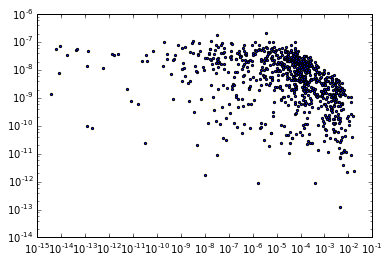

In [14]:
plt.scatter(prob_out['P_binary'], prob_out['P_random'], marker='.')

plt.xlim(1.0e-15, 1.0e-1)
plt.ylim(1.0e-14, 1.0e-6)
plt.xscale('log')
plt.yscale('log')
plt.show()

In [60]:
match = 0

for i in np.arange(len(prob_out_CG)):
    ids = np.where(prob_out['NLTT_1'] == prob_out_CG['NLTT_1'][i])

    if prob_out['NLTT_2'][ids][0] == prob_out_CG['NLTT_2'][i]: 
        match = match + 1
    else:
#         print prob_out['NLTT_1'][ids][0], prob_out['NLTT_2'][ids][0], \
#                 prob_out_CG['NLTT_2'][i], prob_out_CG['P_binary'][i], \
#                 prob_out_CG['P_random'][i]
        
        id1 = np.where(t['NLTT'] == prob_out_CG['NLTT_1'][i])
        id2 = np.where(t['NLTT'] == prob_out_CG['NLTT_2'][i])
        
        
#        id1 = prob_out_CG['NLTT_1'][i]
#        id2 = prob_out_CG['NLTT_2'][i]
        ra1, dec1 = t['ra'][id1][0], t['dec'][id1][0]
        mu_ra1, mu_dec1 = t['mu_ra'][id1][0], t['mu_dec'][id1][0]
        mu_ra_err1, mu_dec_err1 = t['mu_ra_err'][id1][0], t['mu_dec_err'][id1][0]
        ra2, dec2 = t['ra'][id2][0], t['dec'][id2][0]
        mu_ra2, mu_dec2 = t['mu_ra'][id2][0], t['mu_dec'][id2][0]
        mu_ra_err2, mu_dec_err2 = t['mu_ra_err'][id2][0], t['mu_dec_err'][id2][0]
        
        print prob_out_CG['CCode'][i]
        print id1[0], ra1, dec1, mu_ra1, mu_dec1, mu_ra_err1, mu_dec_err1
        print id2[0], ra2, dec2, mu_ra2, mu_dec2, mu_ra_err2, mu_dec_err2
        
print match

6
[13197] 132.15181 -13.8856602 -256.999999 -18.8999996 5.49999997 5.49999997
[13199] 132.163177 -13.9017601 -318.300009 -1.90000003 5.49999997 5.49999997
6
[18261] 175.194717 39.3399811 -189.099997 -122.8 5.49999997 5.49999997
[18283] 175.316406 39.3186264 -134.599999 -197.099999 6.50000013 5.5999998
6
[27825] 258.837402 -26.602829 -473.699987 -1143.90004 1.00000005 1.0
[27839] 259.055664 -26.5461464 -480.399996 -1123.29996 1.0 1.0
3
[29406] 284.408173 53.5205803 254.799992 -52.4000004 5.49999997 5.49999997
[29409] 284.413971 53.5092583 240.999997 -55.9 5.49999997 5.49999997
1
[33462] 339.894287 -12.6151829 228.400007 -151.899993 4.19999985 1.70000002
[33469] 339.923401 -12.5890799 230.399996 -153.899997 5.49999997 5.49999997
1062


### Generate the RPM diagram

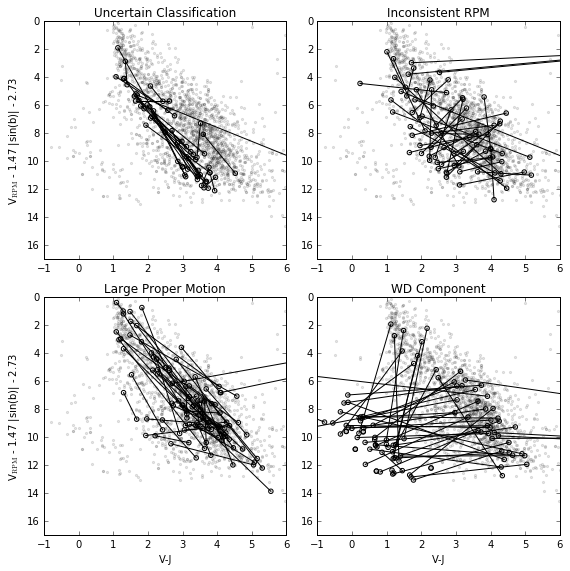

In [90]:
fig, ax = plt.subplots(2,2, figsize=(8,8))

for i in np.arange(len(prob_out_CG)):
        
    ids = np.where(prob_out['NLTT_1'] == prob_out_CG['NLTT_1'][i])

    if prob_out['NLTT_2'][ids][0] == prob_out_CG['NLTT_2'][i]: 
        match = match + 1

        # IDs
        id1 = np.where(t['NLTT'] == prob_out_CG['NLTT_1'][i])
        id2 = np.where(t['NLTT'] == prob_out_CG['NLTT_2'][i])

        # Positions (degrees)
        ra_1, dec_1 = t['ra'][id1][0], t['dec'][id1][0]
        ra_2, dec_2 = t['ra'][id2][0], t['dec'][id2][0]
        # Positions (Galactic)
        c_1 = SkyCoord(ra=ra_1*u.degree, dec=dec_1*u.degree, frame='icrs')
        c_2 = SkyCoord(ra=ra_2*u.degree, dec=dec_2*u.degree, frame='icrs')
        b_1 = c_1.galactic.b.radian
        b_2 = c_2.galactic.b.radian
                
        # Proper motions
        mu_ra1, mu_dec1 = t['mu_ra'][id1][0], t['mu_dec'][id1][0]
        mu_ra2, mu_dec2 = t['mu_ra'][id2][0], t['mu_dec'][id2][0]
        mu_1 = np.sqrt(mu_ra1**2 + mu_dec1**2) / 1.0e3 # in asec/yr
        mu_2 = np.sqrt(mu_ra2**2 + mu_dec2**2) / 1.0e3 # in asec/yr
        
        # Reduced proper motion
        H_rpm_1 = t['V'][id1][0] + 5.0 * np.log10(mu_1) + 5.0
        H_rpm_2 = t['V'][id2][0] + 5.0 * np.log10(mu_2) + 5.0
        
        # Eta proper motion (For comparison with Chaname & Gould 2004)
        eta_rpm_1 = t['V'][id1][0] + 5.0 * np.log10(mu_1) - 1.47 * np.abs(np.sin(b_1)) - 2.73
        eta_rpm_2 = t['V'][id2][0] + 5.0 * np.log10(mu_2) - 1.47 * np.abs(np.sin(b_2)) - 2.73
        
        # Colors
        VJ_1 = t['V'][id1][0] - t['J'][id1][0]
        VJ_2 = t['V'][id2][0] - t['J'][id2][0]
        
        # Plot all matches
        ax[0,0].scatter(VJ_1, eta_rpm_1, marker='.', color='k', alpha=0.1)
        ax[0,0].scatter(VJ_2, eta_rpm_2, marker='.', color='k', alpha=0.1)
        ax[1,0].scatter(VJ_1, eta_rpm_1, marker='.', color='k', alpha=0.1)
        ax[1,0].scatter(VJ_2, eta_rpm_2, marker='.', color='k', alpha=0.1)
        ax[0,1].scatter(VJ_1, eta_rpm_1, marker='.', color='k', alpha=0.1)
        ax[0,1].scatter(VJ_2, eta_rpm_2, marker='.', color='k', alpha=0.1)
        ax[1,1].scatter(VJ_1, eta_rpm_1, marker='.', color='k', alpha=0.1)
        ax[1,1].scatter(VJ_2, eta_rpm_2, marker='.', color='k', alpha=0.1)

        # Plot rejections
        if prob_out_CG['CCode'][i] == 4:
            ax[0,0].plot([VJ_1, VJ_2], [eta_rpm_1, eta_rpm_2], color='k')
            ax[0,0].scatter(VJ_1, eta_rpm_1, marker='o', facecolors='none', edgecolors='k')
            ax[0,0].scatter(VJ_2, eta_rpm_2, marker='o', facecolors='none', edgecolors='k')
        if prob_out_CG['CCode'][i] == 5:
            ax[0,1].plot([VJ_1, VJ_2], [eta_rpm_1, eta_rpm_2], color='k')
            ax[0,1].scatter(VJ_1, eta_rpm_1, marker='o', facecolors='none', edgecolors='k')
            ax[0,1].scatter(VJ_2, eta_rpm_2, marker='o', facecolors='none', edgecolors='k')
        if prob_out_CG['CCode'][i] == 6:
            ax[1,0].plot([VJ_1, VJ_2], [eta_rpm_1, eta_rpm_2], color='k')
            ax[1,0].scatter(VJ_1, eta_rpm_1, marker='o', facecolors='none', edgecolors='k')
            ax[1,0].scatter(VJ_2, eta_rpm_2, marker='o', facecolors='none', edgecolors='k')
        if prob_out_CG['CCode'][i] == 3:
            ax[1,1].plot([VJ_1, VJ_2], [eta_rpm_1, eta_rpm_2], color='k')
            ax[1,1].scatter(VJ_1, eta_rpm_1, marker='o', facecolors='none', edgecolors='k')
            ax[1,1].scatter(VJ_2, eta_rpm_2, marker='o', facecolors='none', edgecolors='k')

    else:
        
        id1 = np.where(t['NLTT'] == prob_out_CG['NLTT_1'][i])
        id2 = np.where(t['NLTT'] == prob_out_CG['NLTT_2'][i])


ax[0,0].set_xlim(-1.0, 6.0)
ax[0,0].set_ylim(17.0, 0.0)
ax[1,0].set_xlim(-1.0, 6.0)
ax[1,0].set_ylim(17.0, 0.0)
ax[0,1].set_xlim(-1.0, 6.0)
ax[0,1].set_ylim(17.0, 0.0)
ax[1,1].set_xlim(-1.0, 6.0)
ax[1,1].set_ylim(17.0, 0.0)

ax[0,0].set_title('Uncertain Classification')
ax[0,1].set_title('Inconsistent RPM')
ax[1,0].set_title('Large Proper Motion')
ax[1,1].set_title('WD Component')

ax[1,0].set_xlabel('V-J')
ax[1,1].set_xlabel('V-J')
ax[0,0].set_ylabel(r'V$_{\rm RPM}$ - 1.47 |sin(b)| - 2.73')
ax[1,0].set_ylabel(r'V$_{\rm RPM}$ - 1.47 |sin(b)| - 2.73')

plt.tight_layout()

plt.savefig('../figures/rNLTT_RPM.pdf')
#plt.show()

/Library/Python/2.7/site-packages/ipykernel/__main__.py:130: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Library/Python/2.7/site-packages/ipykernel/__main__.py:131: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


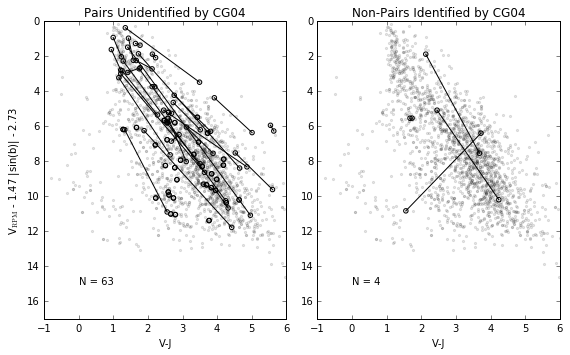

In [137]:
fig, ax = plt.subplots(1, 2, figsize=(8, 5))


nonmatch = 0
for i in np.arange(len(prob_out_CG)):
            
    ids = np.where(prob_out['NLTT_1'] == prob_out_CG['NLTT_1'][i])
    
#     if i == 100: break
    
    if prob_out['NLTT_2'][ids][0] == prob_out_CG['NLTT_2'][i]: 
        match = match + 1
        
        # IDs
        id1 = np.where(t['NLTT'] == prob_out_CG['NLTT_1'][i])
        id2 = np.where(t['NLTT'] == prob_out_CG['NLTT_2'][i])

        # Remove objects with no J or V photometry
        if t['J'][id1][0] < 1.0 or t['J'][id2][0] < 1.0: continue
        if t['V'][id1][0] < 1.0 or t['V'][id2][0] < 1.0: continue

        # Positions (degrees)
        ra_1, dec_1 = t['ra'][id1][0], t['dec'][id1][0]
        ra_2, dec_2 = t['ra'][id2][0], t['dec'][id2][0]
        # Positions (Galactic)
        c_1 = SkyCoord(ra=ra_1*u.degree, dec=dec_1*u.degree, frame='icrs')
        c_2 = SkyCoord(ra=ra_2*u.degree, dec=dec_2*u.degree, frame='icrs')
        b_1 = c_1.galactic.b.radian
        b_2 = c_2.galactic.b.radian
                
        # Proper motions
        mu_ra1, mu_dec1 = t['mu_ra'][id1][0], t['mu_dec'][id1][0]
        mu_ra2, mu_dec2 = t['mu_ra'][id2][0], t['mu_dec'][id2][0]
        mu_1 = np.sqrt(mu_ra1**2 + mu_dec1**2) / 1.0e3 # in asec/yr
        mu_2 = np.sqrt(mu_ra2**2 + mu_dec2**2) / 1.0e3 # in asec/yr
        
        # Reduced proper motion
        H_rpm_1 = t['V'][id1][0] + 5.0 * np.log10(mu_1) + 5.0
        H_rpm_2 = t['V'][id2][0] + 5.0 * np.log10(mu_2) + 5.0
        
        # Eta proper motion (For comparison with Chaname & Gould 2004)
        eta_rpm_1 = t['V'][id1][0] + 5.0 * np.log10(mu_1) - 1.47 * np.abs(np.sin(b_1)) - 2.73
        eta_rpm_2 = t['V'][id2][0] + 5.0 * np.log10(mu_2) - 1.47 * np.abs(np.sin(b_2)) - 2.73
        
        # Colors
        VJ_1 = t['V'][id1][0] - t['J'][id1][0]
        VJ_2 = t['V'][id2][0] - t['J'][id2][0]
        
        # Plot all matches
        ax[0].scatter(VJ_1, eta_rpm_1, marker='.', color='k', alpha=0.1)
        ax[0].scatter(VJ_2, eta_rpm_2, marker='.', color='k', alpha=0.1)
        ax[1].scatter(VJ_1, eta_rpm_1, marker='.', color='k', alpha=0.1)
        ax[1].scatter(VJ_2, eta_rpm_2, marker='.', color='k', alpha=0.1)

    else:
        # IDs
        id1 = np.where(t['NLTT'] == prob_out_CG['NLTT_1'][i])
        id2 = np.where(t['NLTT'] == prob_out_CG['NLTT_2'][i])

        # Remove objects with no J or V photometry
        if t['J'][id1][0] < 1.0 or t['J'][id2][0] < 1.0: continue
        if t['V'][id1][0] < 1.0 or t['V'][id2][0] < 1.0: continue

        # Positions (degrees)
        ra_1, dec_1 = t['ra'][id1][0], t['dec'][id1][0]
        ra_2, dec_2 = t['ra'][id2][0], t['dec'][id2][0]
        # Positions (Galactic)
        c_1 = SkyCoord(ra=ra_1*u.degree, dec=dec_1*u.degree, frame='icrs')
        c_2 = SkyCoord(ra=ra_2*u.degree, dec=dec_2*u.degree, frame='icrs')
        b_1 = c_1.galactic.b.radian
        b_2 = c_2.galactic.b.radian
                
        # Proper motions
        mu_ra1, mu_dec1 = t['mu_ra'][id1][0], t['mu_dec'][id1][0]
        mu_ra2, mu_dec2 = t['mu_ra'][id2][0], t['mu_dec'][id2][0]
        mu_1 = np.sqrt(mu_ra1**2 + mu_dec1**2) / 1.0e3 # in asec/yr
        mu_2 = np.sqrt(mu_ra2**2 + mu_dec2**2) / 1.0e3 # in asec/yr
        
        # Reduced proper motion
        H_rpm_1 = t['V'][id1][0] + 5.0 * np.log10(mu_1) + 5.0
        H_rpm_2 = t['V'][id2][0] + 5.0 * np.log10(mu_2) + 5.0
        
        # Eta proper motion (For comparison with Chaname & Gould 2004)
        eta_rpm_1 = t['V'][id1][0] + 5.0 * np.log10(mu_1) - 1.47 * np.abs(np.sin(b_1)) - 2.73
        eta_rpm_2 = t['V'][id2][0] + 5.0 * np.log10(mu_2) - 1.47 * np.abs(np.sin(b_2)) - 2.73
        
        # Colors
        VJ_1 = t['V'][id1][0] - t['J'][id1][0]
        VJ_2 = t['V'][id2][0] - t['J'][id2][0]
        
        # Plot all matches
        ax[0].scatter(VJ_1, eta_rpm_1, marker='.', color='k', alpha=0.1)
        ax[0].scatter(VJ_2, eta_rpm_2, marker='.', color='k', alpha=0.1)
        ax[1].scatter(VJ_1, eta_rpm_1, marker='.', color='k', alpha=0.1)
        ax[1].scatter(VJ_2, eta_rpm_2, marker='.', color='k', alpha=0.1)

        ax[1].plot([VJ_1, VJ_2], [eta_rpm_1, eta_rpm_2], color='k')
        ax[1].scatter(VJ_1, eta_rpm_1, marker='o', facecolors='none', edgecolors='k')
        ax[1].scatter(VJ_2, eta_rpm_2, marker='o', facecolors='none', edgecolors='k')

        nonmatch = nonmatch + 1




match = 0
#nonmatch = 0
nonmatch_found = 0

id_add = np.array([])
for i in np.arange(len(prob_out)):
        
    ids = np.where(prob_out['NLTT_1'][i] == prob_out_CG['NLTT_1'])
    if prob_out['NLTT_2'][i] == prob_out_CG['NLTT_2'][ids]:
        match = match + 1
    else:
    
#        nonmatch = nonmatch + 1
    
        if prob_out['P_posterior'][i] > 0.5:
            nonmatch_found = nonmatch_found + 1
            id_add = np.append(id_add, i)

    
counter = 0
# Create RPM diagram for identified pairs not in CG04 catalog
for ids in id_add:

    # IDs
    id1 = np.where(t['NLTT'] == prob_out['NLTT_1'][ids])
    id2 = np.where(t['NLTT'] == prob_out['NLTT_2'][ids])
    
    if t['J'][id1][0] < 1.0 or t['J'][id2][0] < 1.0: continue
    if t['V'][id1][0] < 1.0 or t['V'][id2][0] < 1.0: continue
    
    # Positions (degrees)
    ra_1, dec_1 = t['ra'][id1][0], t['dec'][id1][0]
    ra_2, dec_2 = t['ra'][id2][0], t['dec'][id2][0]
    # Positions (Galactic)
    c_1 = SkyCoord(ra=ra_1*u.degree, dec=dec_1*u.degree, frame='icrs')
    c_2 = SkyCoord(ra=ra_2*u.degree, dec=dec_2*u.degree, frame='icrs')
    b_1 = c_1.galactic.b.radian
    b_2 = c_2.galactic.b.radian
                
    # Proper motions
    mu_ra1, mu_dec1 = t['mu_ra'][id1][0], t['mu_dec'][id1][0]
    mu_ra2, mu_dec2 = t['mu_ra'][id2][0], t['mu_dec'][id2][0]
    mu_1 = np.sqrt(mu_ra1**2 + mu_dec1**2) / 1.0e3 # in asec/yr
    mu_2 = np.sqrt(mu_ra2**2 + mu_dec2**2) / 1.0e3 # in asec/yr
        
    # Reduced proper motion
    H_rpm_1 = t['V'][id1][0] + 5.0 * np.log10(mu_1) + 5.0
    H_rpm_2 = t['V'][id2][0] + 5.0 * np.log10(mu_2) + 5.0
        
    # Eta proper motion (For comparison with Chaname & Gould 2004)
    eta_rpm_1 = t['V'][id1][0] + 5.0 * np.log10(mu_1) - 1.47 * np.abs(np.sin(b_1)) - 2.73
    eta_rpm_2 = t['V'][id2][0] + 5.0 * np.log10(mu_2) - 1.47 * np.abs(np.sin(b_2)) - 2.73
        
    # Colors
    VJ_1 = t['V'][id1][0] - t['J'][id1][0]
    VJ_2 = t['V'][id2][0] - t['J'][id2][0]

    # Plot all matches
    ax[0].scatter(VJ_1, eta_rpm_1, marker='.', color='k', alpha=0.1)
    ax[0].scatter(VJ_2, eta_rpm_2, marker='.', color='k', alpha=0.1)

    ax[0].plot([VJ_1, VJ_2], [eta_rpm_1, eta_rpm_2], color='k')
    ax[0].scatter(VJ_1, eta_rpm_1, marker='o', facecolors='none', edgecolors='k')
    ax[0].scatter(VJ_2, eta_rpm_2, marker='o', facecolors='none', edgecolors='k')

    
    counter = counter + 1
#     if np.abs(VJ_1-VJ_2)<0.1 and np.abs(eta_rpm_1-eta_rpm_2)<0.1: 
#         counter = counter
#     else:
#         counter = counter + 1
    
    
ax[0].set_xlim(-1.0, 6.0)
ax[0].set_ylim(17.0, 0.0)
ax[1].set_xlim(-1.0, 6.0)
ax[1].set_ylim(17.0, 0.0)

ax[0].set_title('Pairs Unidentified by CG04')
ax[1].set_title('Non-Pairs Identified by CG04')

ax[0].set_xlabel('V-J')
ax[1].set_xlabel('V-J')
ax[0].set_ylabel(r'V$_{\rm RPM}$ - 1.47 |sin(b)| - 2.73')

ax[0].text(0.0, 15.0, 'N = ' + str(counter))
ax[1].text(0.0, 15.0, 'N = ' + str(nonmatch))

plt.tight_layout()
plt.savefig('../figures/rNLTT_RPM_compare.pdf')
#plt.show()


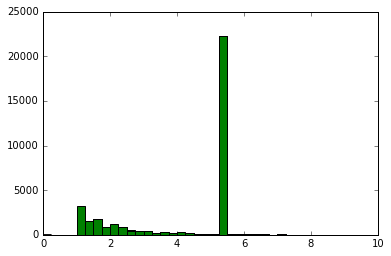

In [141]:
plt.hist(t['mu_ra_err'], bins=40, range=(0,10))
plt.hist(t['mu_dec_err'], bins=40, range=(0,10))
plt.xlim(0.0, 10.0)
plt.show()

In [155]:
ids = np.where(prob_out['P_posterior'] > 0.5)
print "Detected pairs with binary probabilities over 50%:", len(ids[0])
print "Chaname & Gould (2004) pairs:", len(prob_out_CG)
ids = np.intersect1d(np.where(prob_out_CG['P_posterior'] > 0.5), np.where(prob_out_CG['CCode'] < 4))
print "Chaname & Gould (2004) pairs with a probability over 50%:", len(prob_out_CG[ids])

match = 0
match_50 = 0
for i in np.arange(len(prob_out_CG)):
            
    ids = np.where(prob_out['NLTT_1'] == prob_out_CG['NLTT_1'][i])
    
    if prob_out['NLTT_2'][ids][0] == prob_out_CG['NLTT_2'][i]: 
        
        if prob_out_CG['CCode'][i] < 4:
            
            match = match + 1
            if prob_out_CG['P_posterior'][i] > 0.5:
                match_50 = match_50 + 1
            
print "Chaname & Gould (2004) pairs identified:", match
print "Chaname & Gould (2004) pairs with a probability over 50%:", match_50


Detected pairs with binary probabilities over 50%: 946
Chaname & Gould (2004) pairs: 1067
Chaname & Gould (2004) pairs with a probability over 50%: 707
Chaname & Gould (2004) pairs identified: 932
Chaname & Gould (2004) pairs with a probability over 50%: 707


### Let's figure out why we do not redetect some Chaname & Gould (2004) pairs

Num sys with CCode<4: 934
Num sys with P_theta=0: 134
Num sys with P_mu=0: 0
Num sys with P_random=0: 134
Num sys with P_binary=0: 84
Num sys with P_binary<P_random: 221
Num sys with P_posterior > 50%: 713


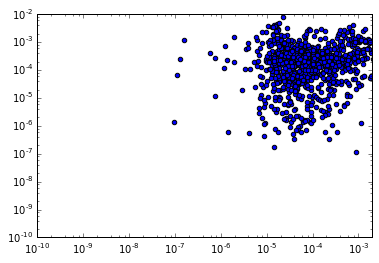

In [199]:
plt.scatter(prob_out_CG['P_theta'], prob_out_CG['P_mu'])
plt.xlim(1.0e-10, 0.002)
plt.ylim(1.0e-10, 0.01)
plt.xscale('log')
plt.yscale('log')

print "Num sys with CCode<4:", len(np.where(prob_out_CG['CCode']<4)[0])

print "Num sys with P_theta=0:", len(np.where(prob_out_CG['P_theta']==0.)[0])
print "Num sys with P_mu=0:", len(np.where(prob_out_CG['P_mu']==0.)[0])
print "Num sys with P_random=0:", len(np.where(prob_out_CG['P_random']==0.)[0])
ids = np.intersect1d(np.where(prob_out_CG['CCode']<4)[0], \
                     np.where(prob_out_CG['P_binary']==0.)[0])
print "Num sys with P_binary=0:", len(ids)
ids = np.intersect1d(np.where(prob_out_CG['CCode']<4)[0], \
                     np.where(prob_out_CG['P_binary']<prob_out_CG['P_random'])[0])
print "Num sys with P_binary<P_random:", len(ids)
ids = np.intersect1d(np.where(prob_out_CG['CCode']<4)[0], \
                     np.where(prob_out_CG['P_posterior']>0.5))
print "Num sys with P_posterior > 50%:", len(ids)



#plt.hist(prob_out_CG['P_theta'], bins=40, color='b', range=[0,0.002], histtype='step')
#plt.hist(prob_out_CG['P_mu'], bins=40, color='g', range=[0,0.002], histtype='step')

#plt.hist(prob_out_CG['P_posterior'], color='k', histtype='step', bins=40, range=[0,1.0])

plt.show()

There are 999 pairs with CCode 1, 2, or 3 in the Chaname & Gould (2004) catalog.

934 of these pairs had counterparts in the rNLTT catalog.

84 of these were not detected since their binary probability was 0.

137 of these have non-zero binary probabilities, but random alignment probabilities are more likely.

We find that, using our method 713 of these pairs, or about 75% are redetected.

In [212]:
counter = 0

for pair in CG_pairs:
    
    # Check if there is a match for star 1
    if len(np.where(pair['NLTT-A'] == t['NLTT'])[0]) == 0:
        if pair['CCode']<4: counter = counter + 1
#        print pair['NLTT-A']
        continue

    # Check if there is a match for star 2
    if len(np.where(pair['NLTT-B'] == t['NLTT'])[0]) == 0:
        if pair['CCode']<4: counter = counter + 1
#        print pair['NLTT-B']

print "Num skipped:", counter

Num skipped: 65


### Let's figure out why Chaname & Gould (2004) did not detect some of our pairs

In [233]:
prob_50 = prob_out[prob_out['P_posterior']>0.50]


match = 0
for i in np.arange(len(prob_50)):
            
    ids = np.where(prob_50['NLTT_1'][i] == prob_out_CG['NLTT_1'])

    if len(ids[0]) < 1: continue
        
    if prob_50['NLTT_2'][i] == prob_out_CG['NLTT_2'][ids][0]:
        if prob_out_CG['CCode'][ids][0] < 4: 
            match = match + 1
    else:
        print prob_50['NLTT_1'][i], prob_50['NLTT_2'][i], prob_out_CG['NLTT_2'][ids][0]
#         # IDs
#         id1 = np.where(t['NLTT'] == prob_out_CG['NLTT_1'][i])
#         id2 = np.where(t['NLTT'] == prob_out_CG['NLTT_2'][i])

print match

20303 20304 20305
44415 44416 44446
47260 47261 47263
54464 54465 54478
711


I just checked:

20303/20304/20305 forms a potential triple system

44415/44416/44446 forms a potential triple system

47260/47261/47263 forms a potential triple system

54464/54465/54478 forms a potential triple system

In [239]:
ids = np.where(prob_out_CG['CCode']<4)[0]

list_NLTT = np.array([])
for i in np.arange(len(ids)):
    if prob_out_CG['P_posterior'][i] > 0.45 and prob_out_CG['P_posterior'][i] < 0.55:
        print prob_out_CG['NLTT_1'][i], prob_out_CG['NLTT_2'][i], prob_out_CG['P_posterior'][i], \
            prob_out_CG['P_random'][i], prob_out_CG['P_binary'][i]
        list_NLTT = np.append(list_NLTT, prob_out_CG['NLTT_1'][i])



for i in np.arange(len(list_NLTT)):
    ids = np.where(list_NLTT[i] == prob_out['NLTT_1'])
    
    print i, ids[0], prob_out['NLTT_1'][ids], prob_out['NLTT_2'][ids], prob_out['P_posterior'][ids], \
        prob_out['P_random'][ids], prob_out['P_binary'][ids]


2053 2057 0.510368221411 4.60568797205e-08 4.80074390891e-08
7538 7539 0.499659060243 2.13698575888e-08 2.13407341113e-08
12486 12488 0.450818481297 6.51324702222e-08 5.34666959989e-08
21938 21941 0.503616349265 3.40105596524e-08 3.45061201416e-08
22121 22125 0.46128223061 6.19790161236e-08 5.3070123974e-08
32108 32113 0.510962234251 7.01420101265e-08 7.32866063097e-08
44505 44506 0.493420998441 4.61979828054e-08 4.49980254445e-08
0 [1355] [2053] [2057] [ 0.99719622] [  4.44140276e-08] [  1.57963556e-05]
1 [4797] [7538] [7539] [ 0.97177481] [  2.20756218e-08] [  7.60049246e-07]
2 [8011] [12486] [12488] [  1.02552358e-07] [  5.92384158e-08] [  6.07503987e-15]
3 [14240] [21938] [21941] [ 0.79649493] [  3.15223541e-08] [  1.23374787e-07]
4 [14362] [22121] [22125] [ 0.22409969] [  5.87541449e-08] [  1.69696870e-08]
5 [20866] [32108] [32113] [ 0.34963549] [  6.85005711e-08] [  3.68258575e-08]
6 [27871] [44505] [44506] [ 0.99397025] [  4.96752370e-08] [  8.18868394e-06]


/Library/Python/2.7/site-packages/ipykernel/__main__.py:18: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Library/Python/2.7/site-packages/ipykernel/__main__.py:19: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


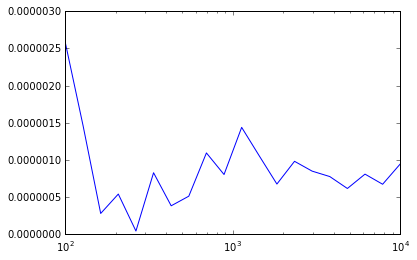

In [255]:
j = 1

id1 = np.where(list_NLTT[j] == t['NLTT'])[0]
ids = np.where(list_NLTT[j] == prob_out['NLTT_1'])
id2 = np.where(prob_out['NLTT_2'][ids] == t['NLTT'])[0]

star1 = t['ra'][id1], t['dec'][id1], t['mu_ra'][id1], t['mu_dec'][id1], t['mu_ra_err'][id1], t['mu_dec_err'][id1]
star2 = t['ra'][id2], t['dec'][id2], t['mu_ra'][id2], t['mu_dec'][id2], t['mu_ra_err'][id2], t['mu_dec_err'][id2]    
theta = P_random.get_theta_proj_degree(star1[0], star1[1], star2[0], star2[1]) * 3600.0
delta_mu = np.sqrt((star1[2]-star2[2])**2 + (star1[3]-star2[3])**2)
delta_mu_ra_err = np.sqrt(star1[4]**2 + star2[4]**2)
delta_mu_dec_err = np.sqrt(star1[5]**2 + star2[5]**2)

num = 20
size = 10**np.linspace(2, 4, num)
prob_binary = np.zeros(num)
for i in np.arange(num):
    delta_mu_ra_sample = normal(loc=(star1[2]-star2[2]), scale=delta_mu_ra_err, size=size[i])
    delta_mu_dec_sample = normal(loc=(star1[3]-star2[3]), scale=delta_mu_dec_err, size=size[i])
    delta_mu_sample = np.sqrt(delta_mu_ra_sample**2 + delta_mu_dec_sample**2)
    prob_binary[i] = 1.0/size[i] * np.sum(P_binary.get_P_binary(theta, delta_mu_sample))

plt.plot(size, prob_binary)
plt.xscale('log')
plt.show()